In [1]:
import pickle5 as pickle
import tensorflow as tf
import numpy as np
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, Conv2D, MaxPool2D, Reshape, Conv2DTranspose,LSTM
from keras.models import Sequential
from keras import Model,models
from keras import backend as K
from keras.models import load_model
from keras import layers
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.optimizers import Adam
from keras.metrics import mean_squared_error
from matplotlib import pyplot as plt
from keras import metrics


## **Question 1**

In [2]:
mnist = tf.keras.datasets.mnist
data=mnist.load_data()

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [4]:

X_train = X_train.reshape((60000, 28, 28))
X_test = X_test.reshape((10000, 28, 28))

X_train, X_test = X_train / 255.0, X_test / 255.0

X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

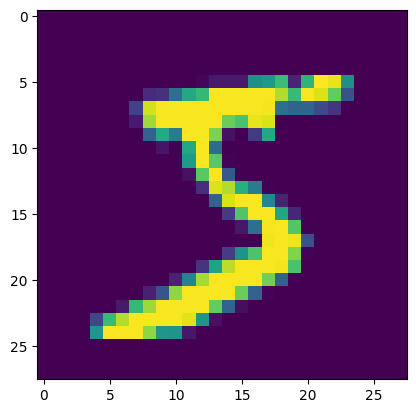

In [5]:
plt.imshow(X_train[0]);


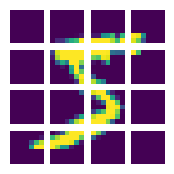

In [6]:
fig, axes=plt.subplots(4, 4, figsize=(2,2))
sample=[]
for i in range(0,X_train[0].shape[0],7):
  for j in range(0,X_train[0].shape[1],7):
    axes[i//7,j//7].imshow(X_train[0][i:i+7,j:j+7])
    sample.append(X_train[0][i:i+7,j:j+7].flatten())
    axes[i//7,j//7].axis('off')

Lets do this via a function.

In [7]:
def patcher(data):
    processed_data=[]
    for n in range(len(data)):
        sample=[]
        for i in range(0,data[n].shape[0],7):
            for j in range(0,data[n].shape[1],7):
                sample.append(data[n][i:i+7,j:j+7].flatten())
        sample=np.array(sample)
        processed_data.append(sample)
        del sample
    return np.array(processed_data)
X_train_reshaped=patcher(X_train)

In [8]:
X_train_reshaped.shape


(60000, 16, 49)

In [9]:
Y_train.shape


(60000,)

In [10]:
X_test_reshaped = patcher(X_test)

In [11]:
X_test_reshaped.shape

(10000, 16, 49)

In [12]:
Y_test.shape


(10000,)

In [13]:
def preprocess(data):
    x = [sample[:-1, :] for sample in data]
    y = [sample[1:, :] for sample in data]
    x = np.array(x)
    y = np.array(y)
    return x, y

x, y = preprocess(X_train_reshaped)
test_x, test_y = preprocess(X_test_reshaped)

Using LSTM Model to carry over both hidden and cell states, so that we can predict using the previous patch.

In [14]:
model = Sequential([
    Input(batch_shape=(100, None, 49)),  # Specify batch input shape
    LSTM(units=64, activation='tanh', kernel_initializer='he_normal', return_sequences=True, stateful=True),
    LSTM(units=64, activation='tanh', kernel_initializer='he_normal', return_sequences=True, stateful=True),
    Dense(units=49, activation='sigmoid', kernel_initializer='he_normal')
])


# Compile the model
model.compile(optimizer=Adam(),loss=mean_squared_error,metrics=['mean_squared_error']);


In [15]:
from keras.callbacks import LambdaCallback


In [16]:
reset_states_callback = LambdaCallback(on_epoch_begin=lambda epoch, logs: model.reset_states())


In [17]:
model_hist=model.fit(x=x,y=y,batch_size=100,epochs=100, validation_data=(test_x,test_y),callbacks=[reset_states_callback])


Epoch 1/100
600/600 [==============================] - 10s 8ms/step - loss: 0.0784 - mean_squared_error: 0.0784 - val_loss: 0.0572 - val_mean_squared_error: 0.0572
Epoch 2/100
600/600 [==============================] - 4s 7ms/step - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0477 - val_mean_squared_error: 0.0477
Epoch 3/100
600/600 [==============================] - 4s 6ms/step - loss: 0.0455 - mean_squared_error: 0.0455 - val_loss: 0.0435 - val_mean_squared_error: 0.0435
Epoch 4/100
600/600 [==============================] - 4s 6ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0408 - val_mean_squared_error: 0.0408
Epoch 5/100
600/600 [==============================] - 4s 6ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0388 - val_mean_squared_error: 0.0388
Epoch 6/100
600/600 [==============================] - 4s 7ms/step - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 7/100
600/600 [

Lets do this for a couple of images to check if the results are accurate.

In [18]:
seed_patches = X_test_reshaped[:100, :8, :]
new_patch = seed_patches
new_patch=new_patch.reshape(-1,8,49)

In [19]:
new_patch=model.predict(new_patch,verbose = 0,batch_size=100)
total_patches=new_patch[:, -1:, :]

In [20]:
new_patch=new_patch[:, -1:, :]

In [21]:
for k in range(7):
    new_patch = model.predict(new_patch,verbose = 0,batch_size=100)
    total_patches = np.concatenate((total_patches, new_patch[:, -1:, :]), axis=1)

In [22]:
full_patches=[]
for i in range(100):
  full_patches.append(np.vstack([seed_patches[i], total_patches[i]]))

In [23]:
full_patches = np.array(full_patches)

In [24]:
full_patches[0].shape

(16, 49)

In [25]:
def reconstruct_image(patch_data):
    image_size = 28
    patch_size = 7
    image = np.zeros((image_size, image_size))
    for row_start in range(0, image_size, patch_size):
        for col_start in range(0, image_size, patch_size):
            current_patch = patch_data[0].reshape(patch_size, patch_size)
            image[row_start:row_start+patch_size, col_start:col_start+patch_size] = current_patch
            patch_data = patch_data[1:]

    return image


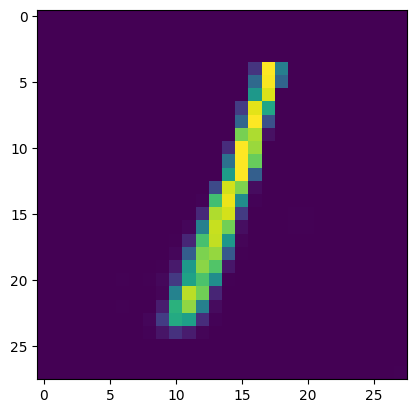

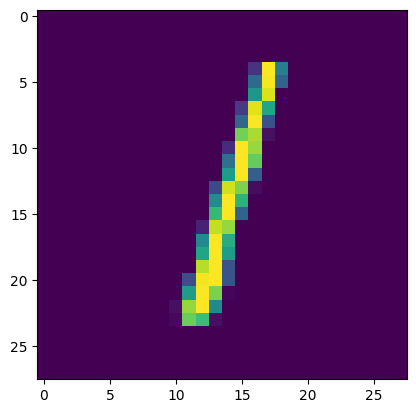

In [26]:
plt.imshow(reconstruct_image(full_patches[2]))
plt.show()
plt.imshow(reconstruct_image(X_test_reshaped[2]))
plt.show()


Now that we see that the reconstructions are going good lets construct a 10X10 matrix to display all digits

In [27]:
def prediction_loop(data):
    seed_patches = data[:100, :8, :]
    new_patch = seed_patches
    new_patch=new_patch.reshape(-1,8,49)
    new_patch.shape
    new_patch=model.predict(new_patch,verbose = 0,batch_size=100)
    total_patches=new_patch[:, -1:, :]
    total_patches.shape
    new_patch=new_patch[:, -1:, :]
    for k in range(7):
        new_patch = model.predict(new_patch,verbose = 0,batch_size=100)
        total_patches = np.concatenate((total_patches, new_patch[:, -1:, :]), axis=1)
    full_patches=[]
    for i in range(100):
      full_patches.append(np.vstack([seed_patches[i], total_patches[i]]))
    full_patches = np.array(full_patches)
    return full_patches

In [28]:
selected_samples = []
for digit in range(10):
    indices = np.where(Y_test == digit)[0][:10]
    selected_samples.extend(indices)

In [29]:
og = []
ri=[]
for index in selected_samples:
    original_img = X_test[index]
    og.append(original_img)
    reconstructed = X_test_reshaped[index]
    ri.append(reconstructed)

In [30]:
ri=np.array(ri)

In [31]:
reconstructed_img = (prediction_loop(ri))


In [32]:
test=reconstruct_image(reconstructed_img[0])

In [33]:
recon=[]
for i in range(100):
    test = reconstruct_image(reconstructed_img[i])
    recon.append(test)

In [34]:
recon=np.array(recon)

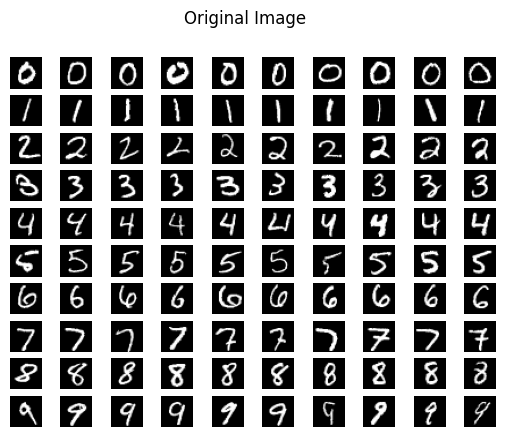

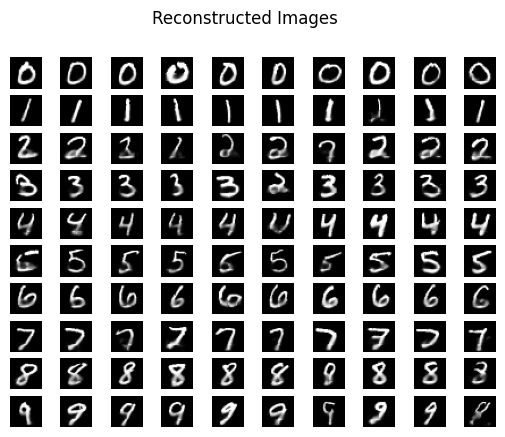

In [35]:
# Set 1: Original Images
fig, axs1 = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        axs1[i, j].imshow(og[i * 10 + j], cmap='gray')
        axs1[i, j].axis('off')
fig.suptitle('Original Image')

# Set 2: Reconstructed Images
fig, axs2 = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        axs2[i, j].imshow(recon[i * 10 + j], cmap='gray')
        axs2[i, j].axis('off')
fig.suptitle('Reconstructed Images')
plt.show()

As we can we are getting almost accurate reconstructions but we do get a couple of images wherein the wrong image is regenerated.

# Question 2

Reference  -
1.   https://blog.keras.io/building-autoencoders-in-keras.html
2.   https://www.tensorflow.org/tutorials/generative/cvae
3. https://keras.io/examples/generative/vae/



In [40]:
with open('hw5_tr7.pkl', 'rb') as pkl_file:
    train_data = pickle.load(pkl_file)

In [41]:
train_data.shape

(6265, 28, 28)

In [42]:
with open('hw5_te7.pkl', 'rb') as pkl_file:
    test_data = pickle.load(pkl_file)


In [43]:
test_data.shape

(1028, 28, 28)

In [44]:
train_data = np.expand_dims(train_data, axis=-1)
test_data = np.expand_dims(test_data, axis=-1)

In [45]:
# Define hyperparameters
original_dim=28*28
latent_dim = 3  # Set to the desired number of latent dimensions
epochs = 20

In [46]:
# Encoder
inputs = layers.Input(shape=(28, 28, 1))
encoder_model= tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,3,strides=2,activation='relu',padding="same"),
    tf.keras.layers.Conv2D(64,3,strides=2,padding="same",activation='relu'),
    tf.keras.layers.Conv2D(128,3,strides=2,padding="same",activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='tanh'),
    ])

encoder_output = encoder_model(inputs)

In [47]:
encoder_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 3)                 6147      
                                                                 
Total params: 98819 (386.01 KB)
Trainable params: 98819 (386.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
z_mean = layers.Dense(latent_dim)(encoder_output)
z_log_var = layers.Dense(latent_dim)(encoder_output)

In [49]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [50]:
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

## Decoder


In [51]:
decoder_model = tf.keras.Sequential([
    layers.Dense(latent_dim, activation='relu'),
    layers.Dense(7*7*64, activation='relu'),
    layers.Reshape(target_shape=(7, 7, 64)),
    layers.Conv2DTranspose(64,3,strides=2, activation='relu',padding='same'),
    layers.Conv2DTranspose(32,3,strides=2, activation='relu',padding='same'),
    layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')
])

decoder_output = decoder_model(z)

In [52]:
vae = Model(inputs, decoder_output)


In [53]:
decoder_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 3)                 12        
                                                                 
 dense_14 (Dense)            (None, 3136)              12544     
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 14, 14, 64)        36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 28, 28, 1)        

In [54]:
xent_loss = original_dim*metrics.binary_crossentropy(K.flatten(inputs), K.flatten(decoder_output))
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
elbo_loss = K.mean(xent_loss + kl_loss)

In [55]:
vae.add_loss(elbo_loss)
vae.compile(optimizer=tf.keras.optimizers.Adam())


In [56]:
# Training
vae.fit(train_data, epochs=100, batch_size=128, validation_data=(test_data, None))

Epoch 1/100
49/49 [==============================] - 4s 17ms/step - loss: 358.0718 - val_loss: 217.4739
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 206.4137 - val_loss: 197.3175
Epoch 3/100
49/49 [==============================] - 0s 10ms/step - loss: 197.8823 - val_loss: 192.9344
Epoch 4/100
49/49 [==============================] - 0s 10ms/step - loss: 194.6755 - val_loss: 190.9920
Epoch 5/100
49/49 [==============================] - 0s 10ms/step - loss: 192.8968 - val_loss: 189.5430
Epoch 6/100
49/49 [==============================] - 1s 11ms/step - loss: 191.5432 - val_loss: 187.8219
Epoch 7/100
49/49 [==============================] - 1s 13ms/step - loss: 190.9136 - val_loss: 187.6584
Epoch 8/100
49/49 [==============================] - 1s 11ms/step - loss: 190.5542 - val_loss: 187.2250
Epoch 9/100
49/49 [==============================] - 1s 12ms/step - loss: 190.4716 - val_loss: 187.5847
Epoch 10/100
49/49 [==============================] - 1s 12ms/st

#### Predicting on test data

In [57]:
def generate_latent_samples(n, scale=5.0):
    latent_samples = np.random.normal(loc=0, scale=1, size=(n, 3))
    latent_samples[:, 0] = np.linspace(-scale, scale, n)  # Varying along the first dimension
    return latent_samples

def generate_decoded_images(decoder, latent_samples):
    decoded_images = []
    for sample in latent_samples:
        z_sample = np.array([sample])
        x_decoded = decoder.predict(z_sample)
        decoded_images.append(x_decoded[0].reshape(28, 28))  # Assuming the image size is 28x28
    return decoded_images

def plot_latent_space(decoder, non_constant_dim, n=15, figsize=15):
    digit_size = 28
    latent_samples = generate_latent_samples(n)
    decoded_images = generate_decoded_images(decoder, latent_samples)

    plt.figure(figsize=(figsize, figsize))

    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(decoded_images[i])
        plt.axis('off')

    plt.show()


#### Ploting the prediction

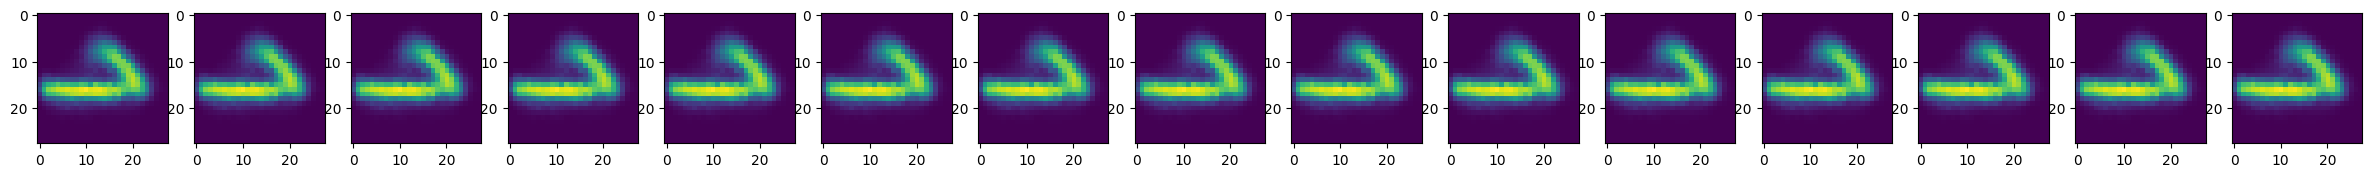

In [ ]:
plot_latent_space(decoder_model, non_constant_dim=1)

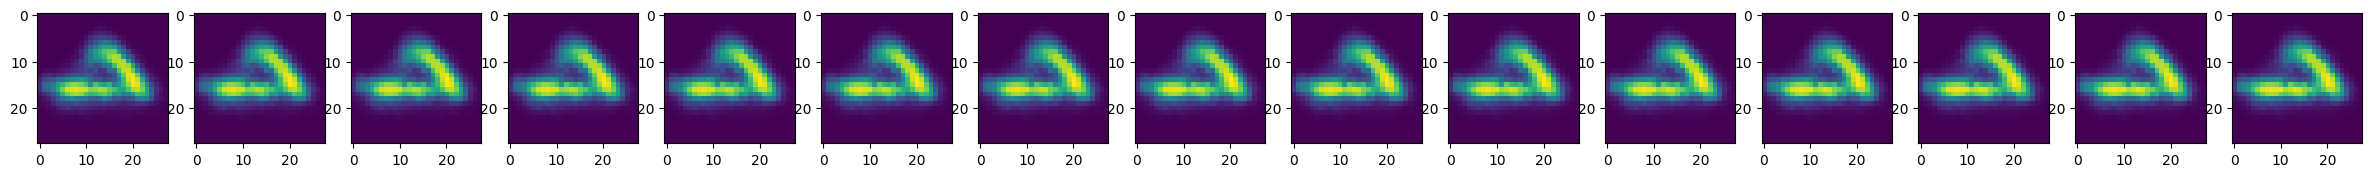

In [ ]:
plot_latent_space(decoder_model, non_constant_dim=2)


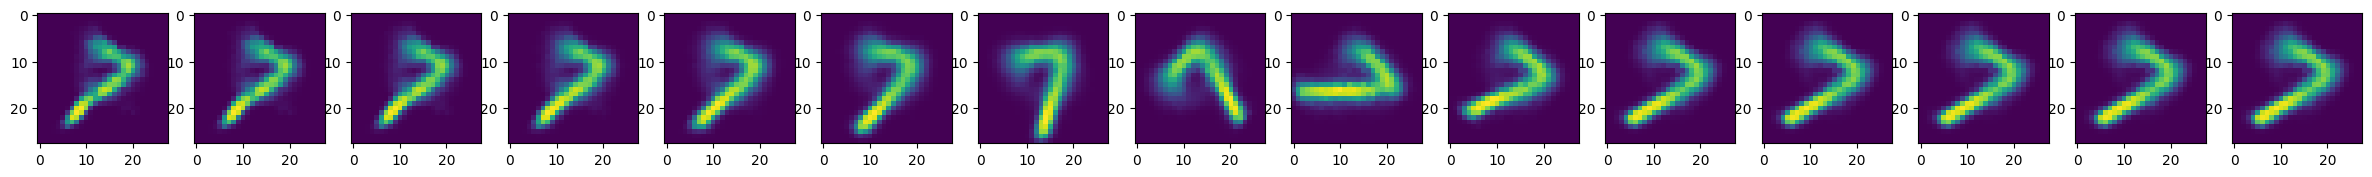

In [ ]:
plot_latent_space(decoder_model, non_constant_dim=3)

So we can see that there are 7's which have been rotated.

# Question 3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, Input, Model
from keras.datasets import mnist
from keras.utils import to_categorical
import tensorflow as tf


In [ ]:
# Generator model
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(200, activation='relu', input_dim=110))
    model.add(layers.Dense(400, activation='relu'))
    model.add(layers.Dense(784, activation='tanh'))
    return model

In [ ]:
# Discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(400, activation='relu', input_dim=794))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
# Combine generator and discriminator into a GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    generator_input = Input((110,))
    labels = generator_input[:,-10:]

    generator_output = generator(generator_input)
    discriminator_input = tf.concat([generator_output,labels],axis = 1)

    discriminator_output = discriminator(discriminator_input)
    gan = Model(generator_input,discriminator_output)

    return gan

In [ ]:
# Load MNIST data
(train_images, train_labels), (_, _) = mnist.load_data()

# Preprocess data
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
train_images = train_images.reshape((train_images.shape[0], 784))
train_labels = to_categorical(train_labels, num_classes=10)

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
# GAN parameters
d = 100  # Random vector size
num_classes = 10
batch_size = 1024

In [ ]:
# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

In [ ]:
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5))

In [ ]:
# Training the GAN
epochs = 200
real = []
fake = []
for epoch in range(epochs):
  for batch in range(int(train_images.shape[0] / batch_size)):
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_images, real_labels = train_images[idx], train_labels[idx]
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(np.concatenate([real_images, real_labels], axis=1), np.ones((batch_size, 1)))

    # Train discriminator on fake data
    random_vectors = np.random.normal(0, 1, (batch_size, d))
    fake_labels = to_categorical(np.random.randint(0, num_classes, batch_size), num_classes=10)
    fake_images = generator.predict(np.concatenate([random_vectors, fake_labels], axis=1),verbose=0)
    d_loss_fake = discriminator.train_on_batch(np.concatenate([fake_images, fake_labels], axis=1), np.zeros((batch_size, 1)))

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    discriminator.trainable = False
    # Train generator
    random_vectors = np.random.normal(0, 1, (batch_size, d))
    valid_labels = to_categorical(np.random.randint(0, num_classes, batch_size), num_classes=10)

    g_loss = gan.train_on_batch(np.concatenate([random_vectors, valid_labels], axis=1), np.ones((batch_size, 1)))

    # Print progress
  d_accuracy_real = 100 * d_loss_real[1]
  d_accuracy_fake = 100 * ( 1-d_loss_fake[1])
  real.append(d_accuracy_real)
  fake.append(d_accuracy_fake)
  print(f"Epoch {epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy Real: {d_accuracy_real}% | D accuracy Fake: {d_accuracy_fake}%] [G loss: {g_loss}]")


Epoch 0/200 [D loss: 0.9519733702572921 | D accuracy Real: 100.0% | D accuracy Fake: 100.0%] [G loss: 0.6176541447639465]
Epoch 1/200 [D loss: 0.17598459124565125 | D accuracy Real: 100.0% | D accuracy Fake: 0.0%] [G loss: 1.8552322387695312]
Epoch 2/200 [D loss: 0.2667330428957939 | D accuracy Real: 95.8984375% | D accuracy Fake: 0.0%] [G loss: 1.9225975275039673]
Epoch 3/200 [D loss: 0.31733427941799164 | D accuracy Real: 97.94921875% | D accuracy Fake: 0.0%] [G loss: 2.0471975803375244]
Epoch 4/200 [D loss: 0.1634054258465767 | D accuracy Real: 99.51171875% | D accuracy Fake: 0.0%] [G loss: 2.2552194595336914]
Epoch 5/200 [D loss: 0.23293229192495346 | D accuracy Real: 96.58203125% | D accuracy Fake: 4.98046875%] [G loss: 2.6924445629119873]
Epoch 6/200 [D loss: 0.38111937046051025 | D accuracy Real: 86.42578125% | D accuracy Fake: 20.21484375%] [G loss: 2.649204969406128]
Epoch 7/200 [D loss: 0.43319328129291534 | D accuracy Real: 91.2109375% | D accuracy Fake: 41.11328125%] [G los

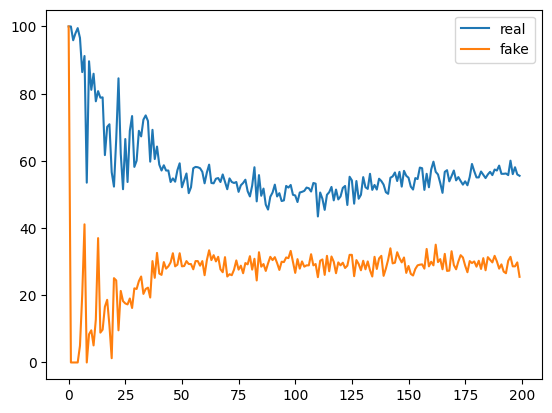

In [ ]:
plt.plot(real, label='real')
plt.plot(fake, label='fake')
plt.legend()

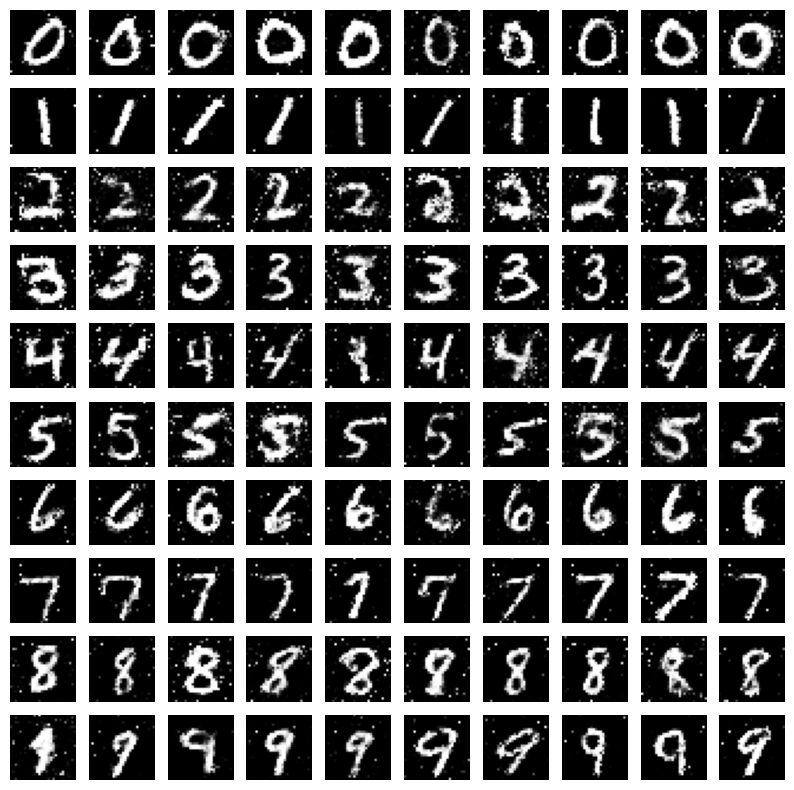

In [ ]:
def generate_examples(generator,i, num_examples=10):
    random_vectors = np.random.normal(0, 1, (10, 100))
    fake_labels = to_categorical(np.random.randint(i, i+1, 10), num_classes=10)
    generated_images = generator.predict(np.concatenate([random_vectors, fake_labels], axis=1),verbose=0)
    return generated_images

# Display generated examples
def display_examples(examples):
    fig, axs = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            axs[i, j].imshow(examples[i][j].reshape(28, 28), cmap='gray')
            axs[i, j].axis('off')
    plt.show()
generated_examples=[]
for i in range(10):
  generated_examples.append(generate_examples(generator,i))
generated_examples=np.array(generated_examples)
display_examples(generated_examples)


We can see that we are almost getting all the digits properly generated but we do disparity in 2's,4's and 9's

#**Question 4**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, Input, Model
from keras.datasets import mnist
from keras.utils import to_categorical
import tensorflow as tf


In [ ]:
# Generator model
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(200, activation='relu', input_dim=200))
    model.add(layers.Dense(400, activation='relu'))
    model.add(layers.Dense(784, activation='tanh'))
    return model

In [ ]:
# Discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Dense(400, activation='relu', input_dim=784))
    model.add(layers.Dense(200, activation='relu'))
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [ ]:
# Combine generator and discriminator into a GAN
def build_gan(generator, discriminator,r):
    discriminator.trainable = False

    generator_input = Input((200,))
    generator_output = generator(generator_input)

    # Extract center patch from the generator input
    labels = generator_input[:, :100]

    # Reshape generator output for comparison with labels
    gen_out = tf.reshape(generator_output, (-1, 28, 28))
    gen_out = gen_out[:, 10:20, 10:20]
    gen_out = tf.reshape(gen_out, [-1, 100])
    print(gen_out.shape)
    print(labels.shape)
    # Mean Squared Error (MSE) loss between labels and reshaped generator output
    mse_loss = tf.reduce_mean(tf.square(labels - gen_out))
    regularizer =r
    mse_loss= mse_loss*regularizer
    # Pass the generator output through the discriminator
    discriminator_output = discriminator(generator_output)

    # Create the GAN model
    gan = Model(generator_input, discriminator_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5))

    # Add the MSE loss to the GAN model
    gan.add_loss(mse_loss)

    return gan

In [ ]:
# Load MNIST data
(train_images, train_labels), (_, _) = mnist.load_data()

# Preprocess data
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
train_images = train_images.reshape((train_images.shape[0], 784))

11490434/11490434 [==============================] - 1s 0us/step


In [ ]:
# GAN parameters
d = 100  # Random vector size
num_classes = 10
batch_size = 1024

In [ ]:
# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])

In [ ]:
gan = build_gan(generator, discriminator,10)


(None, 100)
(None, 100)


In [ ]:
gan.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 sequential (Sequential)     (None, 784)                  434984    ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 1)                    414401    ['sequential[0][0]']          
                                                                                                  
 tf.reshape (TFOpLambda)     (None, 28, 28)               0         ['sequential[0][0]']          
                                                                                              

In [ ]:
# Training the GAN
epochs = 50
real = []
fake = []
for epoch in range(epochs):
  for batch in range(int(train_images.shape[0] / batch_size)):
      # Train discriminator on real data
      idx = np.random.randint(0, train_images.shape[0], batch_size)
      real_images = train_images[idx]

      labels = np.ones((batch_size))
      d_loss_real = discriminator.train_on_batch(real_images,labels)

      # Train discriminator on fake data
      random_vectors = np.random.normal(0, 1.5, (batch_size,100))
      fake_patch = real_images.reshape(-1,28,28)
      fake_patch = fake_patch[:,10:20,10:20]
      fake_patch = fake_patch.reshape(-1,100)
      fake_patch = np.concatenate([fake_patch,random_vectors],axis=1)

      fake_images = generator.predict((fake_patch),verbose=0)
      fake_labels=np.zeros((batch_size,1))
      d_loss_fake = discriminator.train_on_batch(fake_images, fake_labels)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      # Train generator

      g_loss = gan.train_on_batch(fake_patch,labels)

      # Print progress
  d_accuracy_real = 100 * d_loss_real[1]
  d_accuracy_fake = 100 * ( 1-d_loss_fake[1])
  real.append(d_accuracy_real)
  fake.append(d_accuracy_fake)
  print(f"Epoch {epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy Real: {d_accuracy_real}% | D accuracy Fake: {d_accuracy_fake}%] [G loss: {g_loss}]")
  fig, axs = plt.subplots(2, 10)
  for i in range(10):
    axs[0,i].imshow(real_images[i].reshape(28, 28), cmap='gray')
    axs[1,i].imshow(fake_images[i].reshape(28, 28), cmap='gray')
  plt.show()
  # Generate examples for testing


## Original Image

(100, 28, 28)


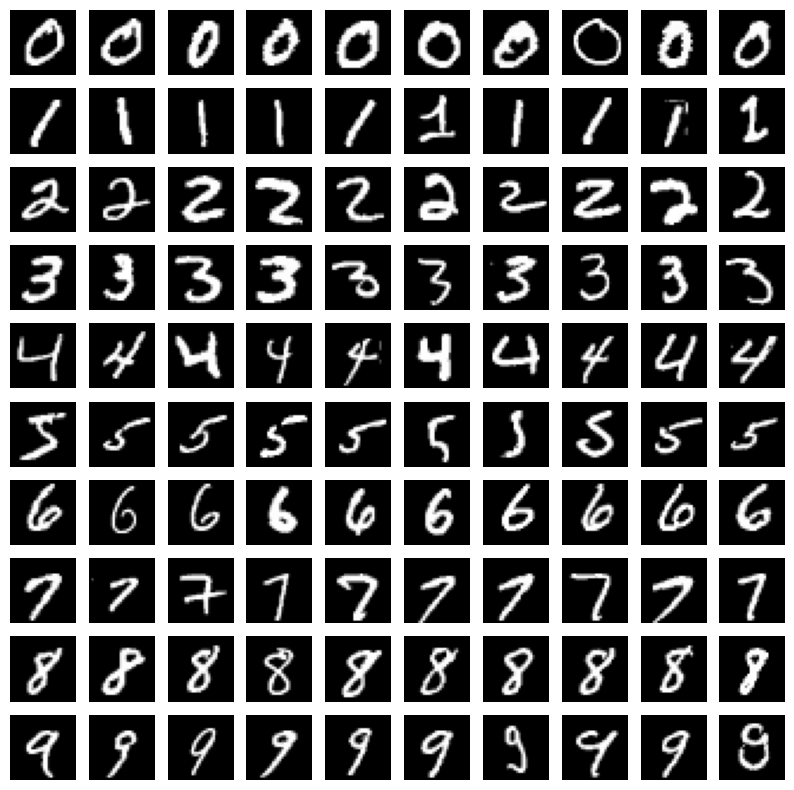

In [ ]:
original_img=[]
for i in range(10):
  selected_samples = np.where(train_labels == i)[0][:10]
  original_img.append(selected_samples)
og = [train_images[index] for index in original_img]
og = np.array(og)
og = og.reshape(-1, 28, 28)
print(og.shape)
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
  for j in range(10):
    axs[i, j].imshow(og[i*10+j].reshape(28, 28), cmap='gray')
    axs[i, j].axis('off')
plt.show()

## Reconstructed Images

In [ ]:
fake_patch = og[:,10:20,10:20]

In [ ]:
random_vectors = np.random.normal(0, 1.5, (100,100))
fake_patch = fake_patch.reshape(-1,100)
fake_patch = np.concatenate([fake_patch,random_vectors],axis=1)


In [ ]:
fake_images = generator.predict((fake_patch),verbose=0)

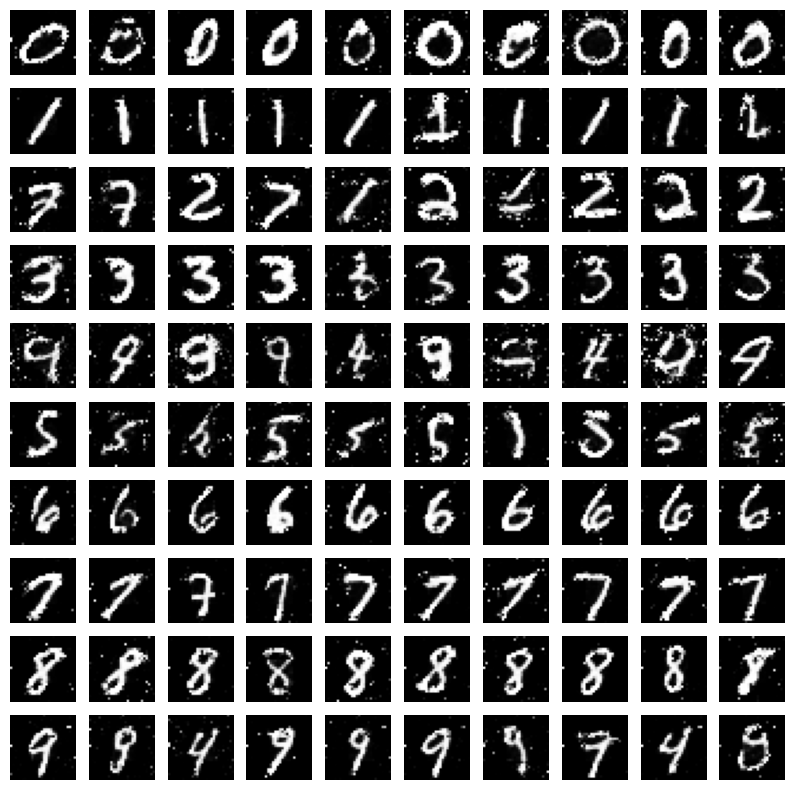

In [ ]:
fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
  for j in range(10):
    axs[i, j].imshow(fake_images[i*10+j].reshape(28, 28), cmap='gray')
    axs[i, j].axis('off')
plt.show()

We do see there are are disparity in 4's and 9's wherein we see 9 is sometimes generating 4's and vice versa. This is because of similar shape of 4 and 9.